Imports
========

In [41]:
import numpy as np
from numpy import sin, cos, sqrt, pi, exp
from numpy.random import rand, randint
from matplotlib import pyplot as plt

Functions
========

Representation and Fitness functions
-----------------

In [42]:
def gamma(dec,x,y,Ls,dim): 
    """ maps decimal representation of an input binary string to a real value in the range [x,y] """
    return x+((y-x)/(2**Ls[dim]-1))*dec

def decode(a,Ls):
    """decodes binary representation to integer/real number"""
    sz=np.size(a,0) #no. of individuals
    n=len(Ls) #no. of dimensions
    mat=np.zeros((sz,n))
    L=np.cumsum(Ls)
    for dim in range(n):
        a_trim=a[:,:L[dim]] if dim==0 else a[:,L[dim-1]:L[dim]]
        col=a_trim.dot(1 << np.arange(a_trim.shape[-1] - 1, -1, -1)) #converting each variable/dimension seperately
#         col=gamma(col,-1,62,Ls,dim) #uncomment if mapping to real values is desired
        mat[:,dim]=col
    return mat

def fit(pop,Ls,f): # TODO: handle -ve values for f(x)
    """returns pop fitnesses (i.e. fitness vector)"""
    n=np.size(pop,0) #no. of individuals
    mat=decode(pop,Ls)
    pop_obj=np.zeros(n) #objective function values for population individuals
    for ir in range(n):
        obj,_=f(mat[ir,:])
        pop_obj[ir]=obj
    pop_fit=1/(pop_obj+1)   #add 1 to denom. to avoid divsion by zero
    _,opt_obj=f(mat[0,:])
    
    return pop_fit, opt_obj

Selection Operators
-----------

In [43]:
def select_RW(pop,fitness,scaled=False): #SUS?
    """RW selection with an option to sigma scale the fitness"""
    fitness=sigma_scale(fitness) if scaled else fitness
    prob=fitness/np.sum(fitness)
    cum_prob=np.cumsum(prob)
    idx=[np.where(cum_prob>rand())[0][0] for i in range(np.size(pop,0))]
    return pop[idx,:]

def sigma_scale(fitness): #sigma scaling
    c=2.; mf=np.mean(fitness); sigma=np.std(fitness);
    fitness_scaled=np.zeros(len(fitness))
    for i,f in enumerate(fitness):
        fitness_scaled[i]=np.max([f-(mf-c*sigma),0])
    return fitness_scaled

def select_LR(pop,fitness,s=1.5):
    """linear ranking-based selection"""
    mu=np.size(pop,0)
    idx=np.argsort(fitness)
    pops=pop[idx,:] #sorted pop according to fitness
    prob=[((2-s)/mu)+((2*i*(s-1))/(mu*(mu-1))) for i in range(mu)]
    cum_prob=np.cumsum(prob)
    idx=[np.where(cum_prob>rand())[0][0] for i in range(mu)]
    return pops[idx,:]

def select_tour(pop,fitness,k=2):
    """tournament selection with replacement"""
    champ=np.zeros_like(pop) #tournament champions
    for i in range(np.size(pop,0)):
        idx=randint(low=0,high=np.size(pop,0),size=k)
        best_f=np.max(fitness[idx])
        champ[i,:]=pop[np.where(fitness==best_f)[0][0],:]
    return champ

def select_elite(): #2 if even 1 if odd 
    #parents that get copied to next gen. w/o xover or mutation (survivor selection method)
    #TODO
    pass

Variation Operators
--------------

In [44]:
def xover_1pt(pop,pc):
    """1 point xover by swapping tails after crossover point"""
    sz=pop.shape; n=int(np.round(sz[0]/2)); L=sz[1];
    prob=rand(n)
    cop=(np.round(rand(n)*(L-1))+1).astype(int) #random crossover points generation
    for i in range(n):
        if prob[i]<pc:
            p1=pop[2*i,:] #parent 1
            p2=pop[0,:] if i==n-1 else pop[2*i+1,:] #parent 2
            t=p1[cop[i]:]
            p1[cop[i]:]=p2[cop[i]:]
            p2[cop[i]:]=t
            pop[2*i,:]=p1
            if i==n-1:
                pop[0,:]=p2
            else:
                pop[2*i+1,:]=p2
    return pop

def xover_npt(pop,pc,n=2):
    sz=pop.shape; m=int(np.round(sz[0]/2)); L=sz[1];
    prob=rand(m)
    cop=[0]*n
    for i in range(m):
        if prob[i]<pc:
            while not(len(cop)==len(set(cop))):
                cop=(np.round(rand(n)*(L-1))+1).astype(int)
                cop=cop.tolist()
            cop=np.sort(np.asarray(cop))
            p1=pop[2*i,:] #parent 1
            p2=pop[0,:] if i==n-1 else pop[2*i+1,:] #parent 2
            for j in range(len(cop)):
                if (len(cop)%2!=0 and j==len(cop)-1):
                    t=p1[cop[j]:]
                    p1[cop[j]:]=p2[cop[j]:]
                    p2[cop[j]:]=t
                elif ((len(cop)%2==0 and j%2==0) or (len(cop)%2!=0 and j!=len(cop)-1)):
                    t=p1[cop[j]:cop[j+1]]
                    p1[cop[j]:cop[j+1]]=p2[cop[j]:cop[j+1]]
                    p2[cop[j]:cop[j+1]]=t
            pop[2*i,:]=p1
            if i==m-1:
                pop[0,:]=p2
            else:
                pop[2*i+1,:]=p2
            
    return pop

def xover_uniform(pop,pc):
    sz=pop.shape; n=int(np.round(sz[0]/2)); L=sz[1];
    prob=rand(n)
    for i in range(n):
        if prob[i]<pc:            
            p1=pop[2*i,:] #parent 1
            p2=pop[0,:] if i==n-1 else pop[2*i+1,:] #parent 2
            c1=np.zeros(len(p1))
            c2=np.zeros(len(p2))
            coin=(np.round(rand(L))).astype(int)
            for j in range(L):
                c1[j]=p1[j] if coin[j]==1 else p2[j]
            c1=c1.astype(int)
            c2=~c1+2
            pop[2*i,:]=c1
            pop[2*i+1,:]=c2
            
    return pop
    
def mutate(pop,pm):
    """bit-flipping mutation"""
    sz=pop.shape
    prob=rand(sz[0],sz[0])
    idx=np.unravel_index(np.where(prob<pm)[0],sz)
    r=idx[0]; c=idx[1];
    for i in range(len(r)):
        pop[r[i],c[i]]=~pop[r[i],c[i]]+2
    
    return pop

Objective Functions (Test Functions)
=========================

In [45]:
def fa(var):#ackley (nD)
    #f(0)=0
    #-30<=x_j<=30 (var domain)
    obj=-20*exp(-0.2*sqrt((1/len(var))*np.sum(var**2)))-exp((1/len(var))*np.sum(cos(2*pi*var)))+20+exp(1)
    opt=[0]*len(var)+[0]
    return obj, opt

def fg(var): #griewangk (nD)
    #f(0)=0
    #-600<=x_j<=600 (var domain)
    obj=(1/4000)*np.sum(var**2)-np.prod(cos(var/sqrt(np.ones(len(var))*range(len(var))+1))+1)
    opt=[0]*len(var)+[0]
    return obj, opt
    
def f1(var): #1D
    #f(0)=1
    obj=np.abs(var)+cos(var) #evaluation of objective function
    opt=[0,1] #(value of function's variables at the optimum, known optimal objective function value)
    return obj, opt

def f3(var): #nD
    #f(0)=0
    obj=np.sum(var**2)
    opt=[0]*len(var)+[0]
    return obj, opt

def f10(var): #nD
    #f(0)=0
    obj=10*len(var)+np.sum(var**2-10*cos(2*pi*var))
    opt=[0]*len(var)+[0]
    return obj, opt

def f12(var): #2D
    #f(1.897,1.006) = -0.5231
    #f(0)=0 #corrected
    obj=0.5+((sin(sqrt(var[0]**2+var[1]**2))**2-0.5)/(1+0.1*(var[0]**2+var[1]**2)))
    opt=[0]*len(var)+[0]
#     opt=[1.897,1.006,-0.5231]
    return obj, opt

Initialization of Parameters
=============

Problem-independant
--------

In [46]:
# np.random.seed(5) #fix only for development
pop_size=10 #no. of individuals #rows
pc=0.75 #xover probability
pm=0.05 #mutation probability
T=500 #max no. of gens.
t=0 #gen. number
best_fit=[]; worst_fit=[]; mean_fit=[];

Problem-dependant
--------

In [47]:
Ls=[5,5] #length of each variable in the chromosome
ff=f3 #choice of the objective/test function
L=np.sum(Ls) #total length of chromosome #columns
select=select_LR #parent selection operator
xover=xover_npt #crossover operator

Implementation
========

In [48]:
pop=randint(2, size=(pop_size,L)); offspring=pop; #population is constructed/Initialized and used as a matrix
fitness,opt_obj=fit(pop,Ls,ff); opt_fit=1/(opt_obj[-1]+1); #adding 1 to denominator to avoid division by zero
best_fit.append(np.max(fitness)); worst_fit.append(np.min(fitness)); mean_fit.append(np.mean(fitness));
best_off=float('nan'); fit_prev=-np.inf;

while not(np.any(fitness==opt_fit) or t==T):
    parents=select(offspring,fitness)
    offspring=xover(parents,pc)
    offspring=mutate(offspring,pm)
    fitness,_=fit(offspring,Ls,ff)
    
    if np.max(fitness)>fit_prev:
        best_off=decode(offspring,Ls)[np.argmax(fitness),:] 
        fit_prev=np.max(fitness)
    best_fit.append(np.max(fitness)); worst_fit.append(np.min(fitness)); mean_fit.append(np.mean(fitness));
    t+=1

Results
=====

In [49]:
np.set_printoptions(suppress=True)

if np.any(fitness==opt_fit):
    opt_sol=decode(offspring,Ls)[np.where(fitness==opt_fit)[0][0],:]
    est_fit=opt_fit
else:
    opt_sol=best_off
    est_fit=fit_prev

best_obj,_=ff(opt_sol)

print("total number of generations elapsed = ",t, '\n')

# print("final fitness vector = ", fitness,'\n')
# print("optimal fitness value = ", opt_fit,'\n')
# print("best found fitness value = ",est_fit ,'\n')

print("optimal objective function value = ", opt_obj[-1],'\n')
print("best found objective function value = ",best_obj ,'\n')

print("variables values at true optimum =",opt_obj[0:-1] ,'\n')
print("variables values at found optimum =",opt_sol ,'\n')

total number of generations elapsed =  26 

optimal objective function value =  0 

best found objective function value =  0.0 

variables values at true optimum = [0, 0] 

variables values at found optimum = [0. 0.] 



Plots
=====

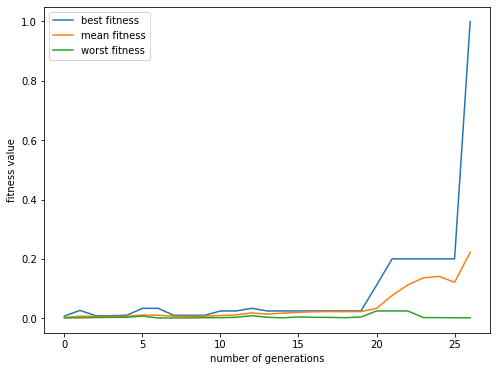

In [50]:
plt.figure(figsize=(8,6))
plt.plot(best_fit,label='best fitness')
plt.plot(mean_fit,label='mean fitness')
plt.plot(worst_fit,label='worst fitness')
plt.legend()
plt.xlabel("number of generations")
plt.ylabel("fitness value")
plt.show()

Comments/Observations:
================

1. As expected, SGA can handle unimodal functions (f1 nad f3) very well, giving always the optimal solution.
2. Since SGA is not equipped to search for and find global optimum of multimodal functions (fa, fg, f10 & f12), finding the global optimum for those fuctions becomes dependant on "luck" (i.e. the seed value of the random number generator which determines essentially most events: population initialization, mutations, crossovers ..etc, and the type of the operators used). For most runs, the SGA settles at local optima. Other factors can also contribute to increasing the probability of reaching that optimum, e.g. increasing population size and maximum allowed number of generations. Additionally, as the number of the objective function's variables increase, the required number of generations or individuals might increase as a result in order to increase the chances of reaching the global optimum.
3. When using FPS methods (e.g. RW and SUS), there is a chance that premature converence happens.
4. Objective functions that will output negative values will cause probelems with RW selction (since it means negative fitness values because fitess is essetiall defined as 1/objective_function). There are ways of course to modify the RW to help it deal with such a situation, like adding a large positive constant number to the fitness values or by using exponential mapping.
5. In general, the objective functions are real-valued with real-valued minima and variables at the minima. However, mapping the binary strings to real values in the decoding part can be problematic. The reason is that the length of the binary representation for each variable and the chosen lower and upper bounds greatly affect the solution (as it affects the mapping resolution and which values can be represented). If these values were not chosen such that the objective function's variable values at its optimum could be obtained by the mapping, then the alorithm will never be able to find it. Since here all such values are integers, it's faster and better to omit this mapping and deal with the problem as if it were integer-valued.
6. When using different selection and crossover operators than the basic ones (i.e. RW selection and 1 point xover), the optimal value is found much faster (in a shorter number of generations).

References:
=======
1. Lecture Slides
2. https://www.obitko.com/tutorials/genetic-algorithms/index.php
3. Introduction to evolutionary computing
4. Hermawanto, D. (2013) Genetic Algorithm For Solving Simple Mathematical Equality Problem. arXiv preprint arXiv:1308.4675